In [1]:
# Se importan librerías y dependencias
from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
from meteostat import Stations, Daily
import pycaret
from pycaret.regression import *
import pandas as pd

In [2]:
pycaret.__version__

'3.2.0'

In [3]:
# Se obtiene los datos
# El ID 87582 correponde a la estación meteorológica Aeroparque Bs. As. Aerodrome
start = datetime(1973, 1, 1) # fecha a partir de la que se tienen datos para esa estación
end = datetime.now() - timedelta(days=1)

data = Daily('87582', start, end)
data = data.fetch()
data

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
time,,,,,,,,,,
1973-01-01,26.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-02,28.7,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-03,24.4,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-04,26.7,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-01-05,27.1,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2023-12-13,25.7,23.0,28.0,4.2,NaN,65.0,14.6,NaN,1006.3,NaN
2023-12-14,24.1,21.0,26.0,0.3,NaN,102.0,17.1,NaN,1007.1,NaN
2023-12-15,26.4,25.0,28.0,3.3,NaN,46.0,11.4,NaN,1007.4,NaN


In [4]:
# Se crean features adicionales
def create_features(data):
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['year'] = data.index.year
    
    Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
    seasons = [('verano', (date(Y,  1,  1),  date(Y,  3, 20))),
               ('otonio', (date(Y,  3, 21),  date(Y,  6, 20))),
               ('invierno', (date(Y,  6, 21),  date(Y,  9, 20))),
               ('primavera', (date(Y,  9, 21),  date(Y, 12, 20))),
               ('verano', (date(Y, 12, 21),  date(Y, 12, 31)))]
    
    def get_season(now):
        now = now.date()
        now = now.replace(year=Y)
        return next(season for season, (start, end) in seasons
                    if start <= now <= end)
    
    data['season'] = pd.Categorical(data.index.map(get_season))

create_features(data)
# Se agregan las temperaturas minima y maxima de dias anteriores como features
DAYS = 5
for i in range(1, DAYS + 1):
    data['tmin-' + str(i)] = data['tmin'].shift(periods=i)
    data['tmax-' + str(i)] = data['tmax'].shift(periods=i)

data_to_predict_tavg = data[['tavg', 'day', 'month', 'year', 'season']]

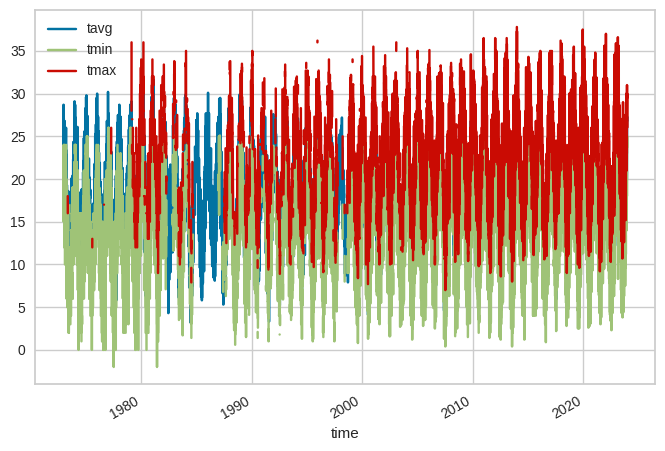

In [5]:
# Plot line chart including average, minimum and maximum temperature
data.plot(y=['tavg', 'tmin', 'tmax'])
plt.show()

In [6]:
print(data.dtypes)
print(data)

tavg       float64
tmin       float64
tmax       float64
prcp       float64
snow       float64
wdir       float64
wspd       float64
wpgt       float64
pres       float64
tsun       float64
day          int64
month        int64
year         int64
season    category
tmin-1     float64
tmax-1     float64
tmin-2     float64
tmax-2     float64
tmin-3     float64
tmax-3     float64
tmin-4     float64
tmax-4     float64
tmin-5     float64
tmax-5     float64
dtype: object
            tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun  \
time                                                                        
1973-01-01  26.7   NaN   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN   
1973-01-02  28.7  23.0   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN   
1973-01-03  24.4  20.0   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN   
1973-01-04  26.7  22.0   NaN   NaN   NaN    NaN   NaN   NaN     NaN   NaN   
1973-01-05  27.1  24.0   NaN   NaN   NaN    NaN   NaN   NaN     NaN 

In [7]:
print(data.head())

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt  pres  tsun  ...  \
time                                                                    ...   
1973-01-01  26.7   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1973-01-02  28.7  23.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1973-01-03  24.4  20.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1973-01-04  26.7  22.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1973-01-05  27.1  24.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

            tmin-1  tmax-1  tmin-2 tmax-2  tmin-3  tmax-3  tmin-4  tmax-4  \
time                                                                        
1973-01-01     NaN     NaN     NaN    NaN     NaN     NaN     NaN     NaN   
1973-01-02     NaN     NaN     NaN    NaN     NaN     NaN     NaN     NaN   
1973-01-03    23.0     NaN     NaN    NaN     NaN     NaN     NaN     NaN   
1973-01-04    20.0     NaN    23.0    NaN     NaN     NaN    

In [8]:
data_to_predict_tmin = data[['tmin', 'tmin-1', 'tmax-1', 'day', 'month', 'year', 'season']]
data_to_predict_tmin.dropna(inplace=True)
data_to_predict_tmin

,tmin,tmin-1,tmax-1,day,month,year,season
time,,,,,,,
1973-01-10,23.0,21.0,30.0,10,1,1973,verano
1973-05-22,7.0,10.0,18.0,22,5,1973,otonio
1974-04-18,13.0,21.0,27.0,18,4,1974,otonio
1975-04-25,15.0,14.0,26.0,25,4,1975,otonio
1975-08-12,8.0,10.0,14.0,12,8,1975,invierno
...,...,...,...,...,...,...,...
2023-12-13,23.0,22.0,31.0,13,12,2023,primavera
2023-12-14,21.0,23.0,28.0,14,12,2023,primavera
2023-12-15,25.0,21.0,26.0,15,12,2023,primavera


In [9]:
s = setup(data_to_predict_tmin, target = 'tmin', session_id = 124)

,Description,Value
0,Session id,124
1,Target,tmin
2,Target type,Regression
3,Original data shape,"(7604, 7)"
4,Transformed data shape,"(7604, 10)"
5,Transformed train set shape,"(5322, 10)"
6,Transformed test set shape,"(2282, 10)"
7,Numeric features,5
8,Categorical features,1
9,Preprocess,True


In [10]:
# compare baseline models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1.7593,5.0536,2.2469,0.8272,0.1975,0.1696,0.2220
catboost,CatBoost Regressor,1.7710,5.1569,2.2695,0.8237,0.1987,0.1699,1.4820
lightgbm,Light Gradient Boosting Machine,1.7757,5.1819,2.2752,0.8228,0.1996,0.1707,31.9170
br,Bayesian Ridge,1.7961,5.2624,2.2927,0.8201,0.2010,0.1730,0.0410
lr,Linear Regression,1.7962,5.2621,2.2926,0.8201,0.2010,0.1731,0.5630
ridge,Ridge Regression,1.7962,5.2621,2.2926,0.8201,0.2010,0.1731,0.0440
lar,Least Angle Regression,1.8206,5.4100,2.3239,0.8151,0.2028,0.1748,0.0440
huber,Huber Regressor,1.7862,5.4284,2.3284,0.8145,0.2038,0.1747,0.0910
rf,Random Forest Regressor,1.8336,5.4783,2.3391,0.8127,0.2035,0.1743,0.6660
en,Elastic Net,1.8423,5.5306,2.3507,0.8110,0.2048,0.1778,0.0410


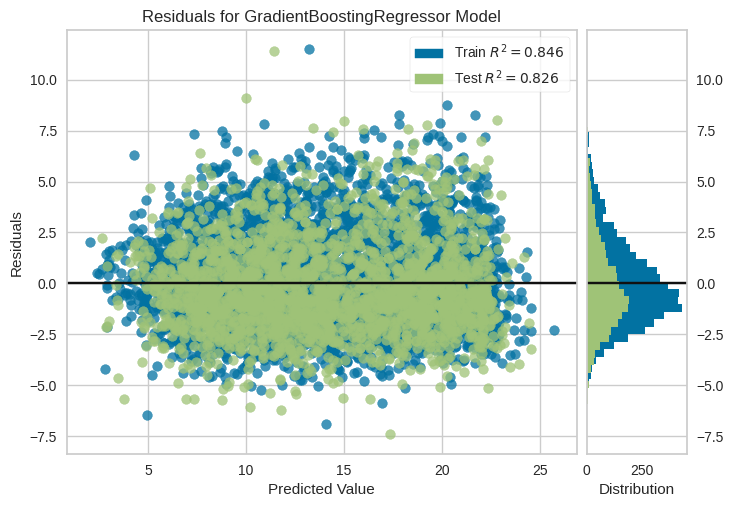

In [11]:
# plot residuals
plot_model(best, plot = 'residuals')

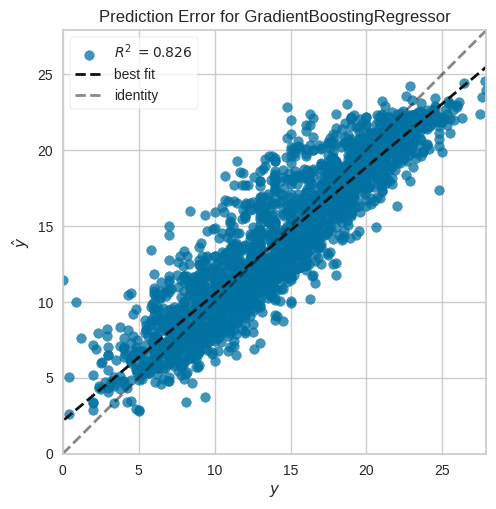

In [12]:
# plot error
plot_model(best, plot = 'error')

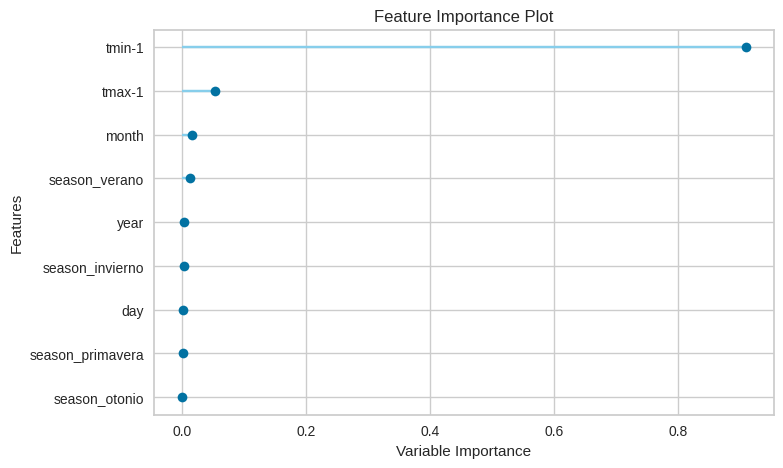

In [13]:
# plot feature importance
plot_model(best, plot = 'feature')

In [14]:
data_to_predict_tmax = data[['tmin', 'tmax', 'tmin-1', 'tmax-1', 'day', 'month', 'year', 'season']]
data_to_predict_tmax.dropna(inplace=True)
data_to_predict_tmax

,tmin,tmax,tmin-1,tmax-1,day,month,year,season
time,,,,,,,,
1973-05-22,7.0,16.0,10.0,18.0,22,5,1973,otonio
1976-08-29,10.0,17.0,11.0,17.0,29,8,1976,invierno
1977-04-24,19.0,23.0,15.0,26.0,24,4,1977,otonio
1979-02-25,23.0,36.0,22.0,28.0,25,2,1979,verano
1979-03-15,20.0,24.0,19.0,23.0,15,3,1979,verano
...,...,...,...,...,...,...,...,...
2023-12-13,23.0,28.0,22.0,31.0,13,12,2023,primavera
2023-12-14,21.0,26.0,23.0,28.0,14,12,2023,primavera
2023-12-15,25.0,28.0,21.0,26.0,15,12,2023,primavera


In [15]:
s = setup(data_to_predict_tmax, target = 'tmax', session_id = 125)

,Description,Value
0,Session id,125
1,Target,tmax
2,Target type,Regression
3,Original data shape,"(6008, 8)"
4,Transformed data shape,"(6008, 11)"
5,Transformed train set shape,"(4205, 11)"
6,Transformed test set shape,"(1803, 11)"
7,Numeric features,6
8,Categorical features,1
9,Preprocess,True


In [16]:
# compare baseline models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,1.4927,3.9278,1.9783,0.8837,0.0936,0.0735,28.8830
catboost,CatBoost Regressor,1.4999,3.9385,1.9814,0.8835,0.0938,0.0738,1.4860
gbr,Gradient Boosting Regressor,1.5195,3.9836,1.9932,0.8822,0.0944,0.0750,0.2080
rf,Random Forest Regressor,1.5145,4.0702,2.0149,0.8796,0.0952,0.0745,0.6130
et,Extra Trees Regressor,1.5326,4.1045,2.0232,0.8785,0.0956,0.0754,0.5030
lr,Linear Regression,1.5685,4.1237,2.0283,0.8781,0.0962,0.0773,0.0430
ridge,Ridge Regression,1.5685,4.1236,2.0283,0.8781,0.0962,0.0773,0.0400
lar,Least Angle Regression,1.5685,4.1237,2.0283,0.8781,0.0962,0.0773,0.0410
br,Bayesian Ridge,1.5682,4.1236,2.0283,0.8781,0.0962,0.0773,0.0410
en,Elastic Net,1.5849,4.2190,2.0518,0.8752,0.0972,0.0783,0.0390


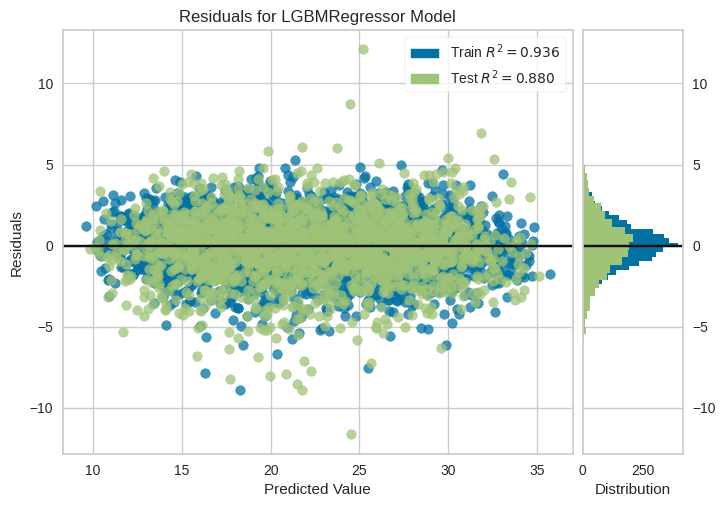

In [17]:
# plot residuals
plot_model(best, plot = 'residuals')

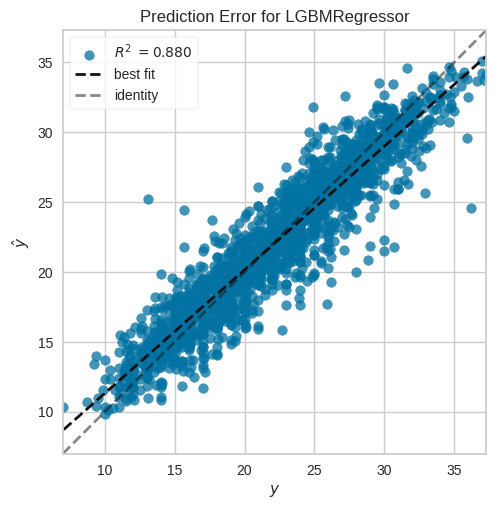

In [18]:
# plot error
plot_model(best, plot = 'error')

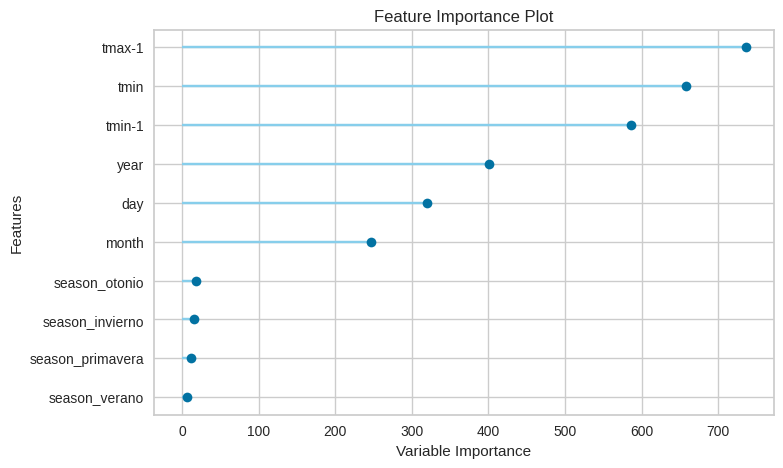

In [19]:
# plot feature importance
plot_model(best, plot = 'feature')